In [108]:
# Import packages
import os
import re
import PyPDF2
import nltk
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.probability import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenne\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lenne\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# Download the pdfs from our S3 bucket
#import requests
#
#url = 'https://mda-georgia-bucket.s3.eu-central-1.amazonaws.com/Articles/article10.pdf'
#
#response = requests.get(url)
#with open('local_file.pdf', 'wb') as f:
#    f.write(response.content)
#print('PDF file downloaded successfully.')

In [144]:
def extract_text_from_pdf(file_path):
    if not os.path.exists(file_path):
        print("File not found:", file_path)
        return ""

    try:
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            num_pages = len(pdf_reader.pages)
            text = ""

            for page_number in range(num_pages):
                page = pdf_reader.pages[page_number]
                text += page.extract_text()

        # Remove linebreaks
        text = text.replace('\n', ' ')

        return text
    except Exception as e:
        print("Error occurred while extracting text:", str(e))
        return ""



# Define a function to preprocess the text
def preprocess_text(text, extra_stop_words=[]):
    # Remove noise, white spaces, and punctuation using regular expressions
    text = re.sub(r'\s+', ' ', text)  # Remove extra white spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d', '', text)  # Remove numbers

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    # Add extra stopwords
    stop_words.update(extra_stop_words)  
    # stop_words.update(["noise"]) # not sure whether or not to put noise as a stopword
    tokens = [token for token in tokens if token not in stop_words]

    # Remove tokens containing numbers or the word "http", remove stopwords, remove tokens of length <=2
    tokens = [token for token in tokens if not any(char.isdigit() for char in token)
              and "http" not in token and "www" not in token and token.lower() not in stop_words
              and not (len(token) <= 2)]


    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    stop_words.update(["study"]) # this can only be added here to the stop words or it will still appear in the results (because can be noun, verb, ...)
    tokens = [token for token in tokens if token not in stop_words]

    return tokens


# Define a function to perform part of speech tagging
#def pos_tagging(tokens):
#    tagged_tokens = pos_tag(tokens)
#    return tagged_tokens
    

# Define a function to extract bag of words and 2-grams
def extract_bag_of_words(tokens):
    # Bag of Words
    word_freq = FreqDist(tokens)
    most_common_words = word_freq.most_common()

    # 2-grams
    bigram_measures = BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokens)
    n_gram_scores = finder.score_ngrams(bigram_measures.raw_freq)
    most_common_2grams = sorted(n_gram_scores, key=lambda x: x[1], reverse=True)

    return most_common_words, most_common_2grams

# Define a function to summarize the text with sentences that contain many common words
def text_summarization(text, common_words_list, extra_stopwords=[]): #possibility to add words that may not appear in the selected sentences; default of extra stopwords is empty
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)

    # Extract the 10 most frequent words from the bag_of_words results ((extra) stopwords don't occur in these results)
    common_words = [word for word, _ in common_words_list[:10]]  # Extract only the words and not the frequencies

    # Select short sentences that contain the most frequent words
    selected_sentences = []
    for sentence in sentences:
        sentence_tokens = [token.lower() for token in word_tokenize(sentence)]  # Convert tokens to lowercase
        common_words_count = sum(1 for token in sentence_tokens if token in common_words)
        if common_words_count >= 6 and not any(word in sentence_tokens for word in extra_stopwords): #extra_stopwords may NOT appear in the sentence, default stopwords are allowed
            selected_sentences.append(sentence)

    # Check if any selected sentences were found
    if len(selected_sentences) == 0:
        print("No sentences found where common words occur more than once.")

    return selected_sentences


# Define a function for sentiment analysis
def sentiment_analysis(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores


# Define a function to generate a word cloud
def generate_word_cloud(tokens, max_words=15):
    text = ' '.join(tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=max_words).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


# Define a function for topic modelling (Latent Dirichlet Allocation)
def latent_dirichlet_allocation(tokens, num_topics=3):
    if len(tokens) == 0:
        print("No tokens available for topic modeling.")
        return []

    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([' '.join(tokens)])

    if len(vectorizer.get_feature_names()) == 0:
        print("Empty vocabulary. The documents may only contain stop words.")
        return []

    feature_names = vectorizer.get_feature_names()

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    topic_keywords = []
    for topic_idx, topic in enumerate(lda.components_):
        top_indices = topic.argsort()[:-11:-1]
        topic_keywords.append([feature_names[i] for i in top_indices])

    return topic_keywords

Processed all files
Most common words: [('noise', 2850), ('level', 739), ('health', 713), ('effect', 652), ('sound', 528), ('exposure', 522), ('pollution', 454), ('environmental', 384), ('frequency', 313), ('traffic', 292), ('acoustic', 277), ('sleep', 266), ('dba', 255), ('source', 253), ('response', 249)]
Most common 2-grams: [(('noise', 'pollution'), 0.004101113159286092), (('noise', 'level'), 0.0033580543290321657), (('noise', 'exposure'), 0.0025578371272202455), (('low', 'frequency'), 0.0019576742258613053), (('effect', 'noise'), 0.0019148054471928096), (('public', 'health'), 0.0016861719609608322), (('environmental', 'noise'), 0.0016433031822923364), (('air', 'pollution'), 0.0015718552178448436), (('sound', 'pressure'), 0.001457538474728855), (('pressure', 'level'), 0.0013289321387233678), (('hearing', 'loss'), 0.0012431945813863763), (('traffic', 'noise'), 0.0012146153956073792), (('frequency', 'noise'), 0.0012003258027178806), (('sleep', 'disturbance'), 0.0011717466169388834), 

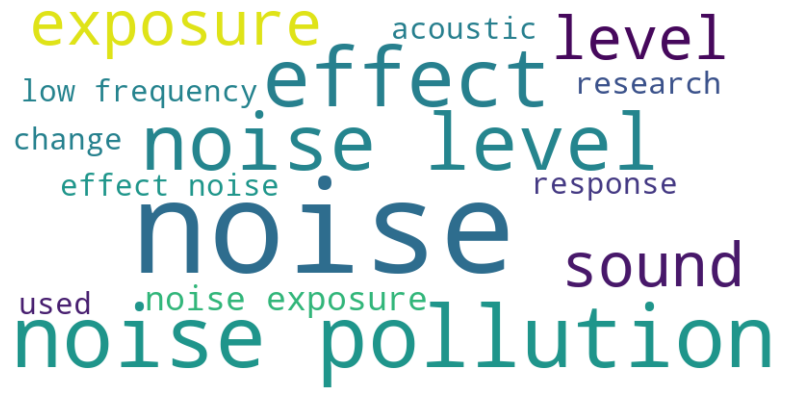

39 selected sentences: ['Health Effects of Noise Pollution Auditory Health Effects of Noise Pollution 1.Tinnitus is an abnormal ringing sound arising mainly in- side the body.', 'The environmental noise measurement parameters used in  this study were: L Aeq8-17;  the average noise level during the  measurement period (8-17hrs), which includes all noise  events; L A90: the noise level exceeded for 90% of the time,  general representative of the steady background noise at a  location, and; L APeak; peak sound level which is the  maximum instantaneous sound level in dB(A).', 'Using the  specific interval measurements for 8 hours from 8 to 17  hours,  L Aeq8-17  was calculated for each noise source using  equation (1) in which L Aeq8-17  is the continuous equivalent  A-weighted noise pressure level from 8 to 17 hours; n is  the number of 10 minutes measurements between 8.00 and  17.00 hours; LA eq(i/10)  is the A-weighted continuous noise  pressure measurement in the one 10 minutes instant

In [145]:
# Get the folder_path where the file is in (= current working directory)
folder_path = os.getcwd()


# Concatenate all article texts together
concatenated_text = "" # initialize empty variable to store the concatenated_text in
for file_name in os.listdir(folder_path):
    if file_name.endswith(".pdf"):
        file_path = os.path.join(folder_path, file_name)
        text = extract_text_from_pdf(file_path)
        concatenated_text += text

# Define extra stop words: "et", "al", "accessed" and months to stopwords (to remove "accessed {monthname}"), ...
extra_stop_words = ["et", "al", "doi", "vol", "accessed", "january", "february", "march", "april", "may", "june", "august", "september", "october", "november", "december", "table", "keywords", "model",
                    "british", "bulletin", "downloaded", "guest", "bcn", "patient", "cluster", "model", "results", "data", "analysis", "table", "value", "contents", "randomizations", "methods", "measurement"]

# Apply NLP to the concatenated text
preprocessed_text = preprocess_text(concatenated_text, extra_stop_words)
#tagged_tokens = pos_tagging(preprocessed_text)
most_common_words, most_common_2grams = extract_bag_of_words(preprocessed_text)
selected_sentences = text_summarization(concatenated_text, most_common_words, extra_stop_words)
sentiment_scores = sentiment_analysis(concatenated_text)
#topic_keywords_3 = latent_dirichlet_allocation(preprocessed_text)
#topic_keywords_1 = latent_dirichlet_allocation(preprocessed_text, num_topics=1)


# Print the results
print("Processed all files")
print("Most common words:", most_common_words[:15])
print("Most common 2-grams:", most_common_2grams[:30])
generate_word_cloud(preprocessed_text)
print(f"{len(selected_sentences)} selected sentences:", selected_sentences)
print("Sentiment scores:", sentiment_scores)
#print("Topic keywords:", topic_keywords_3)
#print("Topic keywords:", topic_keywords_1)


In [110]:
# get an error above: debug by seeing if everything works for article 1
current_dir = os.getcwd()

# Specify the PDF file name
pdf_file_name = "Article2.pdf"

# Construct the full path to the PDF file
pdf_file_path = os.path.join(current_dir, pdf_file_name)

text = extract_text_from_pdf(pdf_file_path)
print(text)

British Medical Bulletin  2003; 68: 243–257 British Medical Bulletin , Vol. 68 © The British Council 2003; all rights reserved
DOI: 10.1093/bmb/ldg033Noise pollution: non-aud itory effects on health
Stephen A Stansfeld and Mark P Matheson
Department of Psychiatry, Medical Sciences Building, Queen Mary, University of London, 
London, UK
Noise is a prominent feature of the envi ronment including noise from transport, 
industry and neighbours. Exposure to transport noise distu rbs sleep in the 
laboratory, but not generally in field studies where adaptation occurs. Noise 
interferes in complex task performance, modifies social be haviour and causes 
annoyance. Studies of occupational and environmental noise exposure suggest 
an association with  hypertension, whereas communi ty studies show only weak 
relationships between noise and cardiovasc ular disease. Aircra ft and road traffic 
noise exposure are associated  with psychological symptoms  but not with clinically 
defined psychiatric 

In [111]:
preprocessed_text = preprocess_text(text)
preprocessed_text[:50]

['medical',
 'medical',
 'council',
 'right',
 'reserved',
 'bmbldgnoise',
 'pollution',
 'nonaud',
 'itory',
 'effect',
 'health',
 'stephen',
 'stansfeld',
 'mark',
 'matheson',
 'department',
 'psychiatry',
 'medical',
 'science',
 'building',
 'queen',
 'mary',
 'university',
 'london',
 'london',
 'noise',
 'prominent',
 'feature',
 'envi',
 'ronment',
 'including',
 'noise',
 'transport',
 'industry',
 'neighbour',
 'exposure',
 'transport',
 'noise',
 'distu',
 'rb',
 'sleep',
 'laboratory',
 'generally',
 'field',
 'adaptation',
 'occurs',
 'noise',
 'interferes',
 'complex',
 'task']

In [106]:
tagged_tokens = pos_tagging(preprocessed_text)
tagged_tokens[:50]

[('medical', 'JJ'),
 ('medical', 'JJ'),
 ('council', 'NN'),
 ('right', 'RB'),
 ('reserved', 'VBD'),
 ('bmbldgnoise', 'JJ'),
 ('pollution', 'NN'),
 ('nonaud', 'NN'),
 ('itory', 'JJ'),
 ('effect', 'NN'),
 ('health', 'NN'),
 ('stephen', 'NN'),
 ('stansfeld', 'VBD'),
 ('mark', 'NNP'),
 ('matheson', 'NNP'),
 ('department', 'NN'),
 ('psychiatry', 'NN'),
 ('medical', 'JJ'),
 ('science', 'NN'),
 ('building', 'NN'),
 ('queen', 'NN'),
 ('mary', 'JJ'),
 ('university', 'NN'),
 ('london', 'NN'),
 ('london', 'JJ'),
 ('noise', 'NN'),
 ('prominent', 'JJ'),
 ('feature', 'NN'),
 ('envi', 'FW'),
 ('ronment', 'NN'),
 ('including', 'VBG'),
 ('noise', 'JJ'),
 ('transport', 'NN'),
 ('industry', 'NN'),
 ('neighbour', 'NN'),
 ('exposure', 'NN'),
 ('transport', 'NN'),
 ('noise', 'NN'),
 ('distu', 'NN'),
 ('rb', 'NN'),
 ('sleep', 'JJ'),
 ('laboratory', 'NN'),
 ('generally', 'RB'),
 ('field', 'NN'),
 ('adaptation', 'NN'),
 ('occurs', 'VBZ'),
 ('noise', 'JJ'),
 ('interferes', 'NNS'),
 ('complex', 'JJ'),
 ('task', 

In [112]:
most_common_words, most_common_2grams = extract_bag_of_words(preprocessed_text)
print(most_common_words[:10])
print(most_common_2grams[:10])

[('noise', 290), ('effect', 87), ('exposure', 78), ('health', 67), ('child', 59), ('aircraft', 39), ('annoyance', 32), ('level', 32), ('blood', 29), ('pressure', 29)]
[(('noise', 'exposure'), 0.013063840276066059), (('aircraft', 'noise'), 0.009120039438008381), (('blood', 'pressure'), 0.006408676361843727), (('effect', 'noise'), 0.004929751047572098), (('pollution', 'health'), 0.0034508257333004683), (('sleep', 'disturbance'), 0.0034508257333004683), (('traffic', 'noise'), 0.0032043381809218636), (('noise', 'annoyance'), 0.0029578506285432584), (('road', 'traffic'), 0.0029578506285432584), (('noise', 'level'), 0.0027113630761646536)]


In [119]:
# make sure that the preprocessing of the words is added here too, tokenize the words back to sentences if it's possible (for this part)
selected_sentences = text_summarization(text, most_common_words)
selected_sentences

No sentences found where common words occur more than once.


[]

In [84]:
sentiment_scores = sentiment_analysis(text)
sentiment_scores

{'neg': 0.095, 'neu': 0.867, 'pos': 0.037, 'compound': -0.9999}

In [85]:
# here is a problem
topic_keywords = latent_dirichlet_allocation(preprocessed_text, num_topics=5)

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

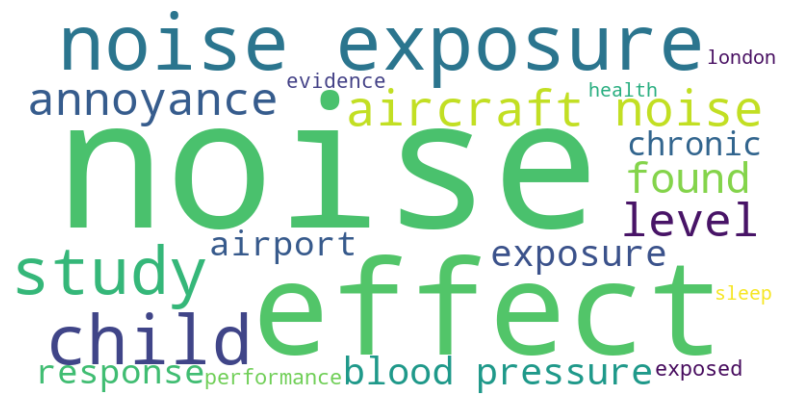

In [86]:
generate_word_cloud(preprocessed_text)

In [128]:
    word_freq = FreqDist(preprocessed_text)
    most_common_words = [word for word, _ in word_freq.most_common(10)]
most_common_words

['noise',
 'level',
 'health',
 'effect',
 'sound',
 'exposure',
 'pollution',
 'environmental',
 'frequency',
 'traffic']

In [ ]:
# OLD VERSION
# Define a function for text summarization
def text_summarization(text):
    sentences = sent_tokenize(text)

    # Extract the most frequent words
    tokens = word_tokenize(text)
    word_freq = FreqDist(tokens)
    most_common_words = [word for word, _ in word_freq.most_common(10)]

    # Select short sentences that contain the most frequent words
    selected_sentences = []
    for sentence in sentences:
        sentence_tokens = word_tokenize(sentence)
        common_words_count = sum(1 for token in sentence_tokens if token in most_common_words)
        if common_words_count >= 3:
            selected_sentences.append(sentence)

    return selected_sentences